### Import packages

In [38]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             
from numpy.random import choice

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data for stations and transport lines

In [43]:
# Import stations and lines from csv 
df1 = pd.read_csv("Data/stations.csv", sep=";")
df2 = pd.read_csv("Data/lijnen.csv", sep=";")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x)) 
df1.loc[:,'HalteLon'] = df1.loc[:,'HalteLon'].apply(lambda x: float(str(x).replace(',','.')))
df1.loc[:,'HalteLat'] = df1.loc[:,'HalteLat'].apply(lambda x: float(str(x).replace(',','.')))

In [44]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [45]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

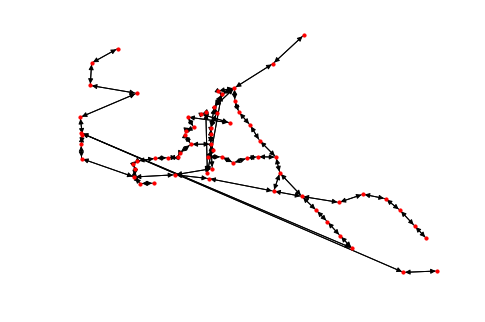

<Figure size 1440x1440 with 0 Axes>

In [53]:
# Plot the network
nx.draw(FG, positions, node_size=10)
plt.show()

### Route calculation and choice functions

In [17]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["waiting"] = int(random.random() * 10)
    route_info["duration"] += (route_info["transfers"] * 3)
    
    return route_info

In [18]:
def choice(routes, classname):
    if classname == 0:
        minimum = routes[0][0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i][0]["duration"] < minimum:
                minimum = routes[i][0]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i][0]["duration"] == minimum:
                if routes[i][0]["transfers"] < routes[index][0]["transfers"]:
                    index = i

    elif classname == 1:
        minimum = routes[0][0]["waiting"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least waiting time
            if routes[i][0]["waiting"] < minimum:
                minimum = routes[i][0]["waiting"]
                index = i

            # If waiting time is the same, save the route with the shortest duration
            elif routes[i][0]["waiting"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i

    elif classname == 2:
        minimum = routes[0][0]["transfers"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least transfers
            if routes[i][0]["transfers"] < minimum:
                minimum = routes[i][0]["transfers"]
                index = i

            # If the num of transfers is the same, save the route with the shortes duration
            elif routes[i][0]["transfers"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i
                    
    return routes[index][0], routes[index][1]

### Create and spawn vehicles

In [8]:
def generate_vehicle(line, environment, linename):
    """ Generate a metro """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

In [9]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60 * 60)
    while True:
        vehicle = generate_vehicle(lines[name][x], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(frequency * 60)

### Generate passengers based on data

In [86]:
origin = pd.read_csv("Data/origin.csv")
destination = pd.read_csv("Data/destination.csv")

gvbdata = {}

hours = list(set(origin['hour'].tolist()))

for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    sums = df['sum'].tolist()
    total = df['sum'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(sums[i]/total)
        
    gvbdata[hour] = (total, stops, percentages)
    break
    
variable = gvbdata['20:00 - 20:59']
draw = choice(variable[1], 2, p=variable[2])
draw

gvbdata

array(['Wibautstraat', 'Centraal Station'], dtype='<U22')

In [11]:
def generate_passenger(origin, destination, classname, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        routes.append(((route_calculation(path, FG)), path))

    # Travel direction and route information
    route_info, route = choice(routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [12]:
def passengers(env, classname, data):
    # make a variable with all chances here based on the hour the simulation is in
    while True:
        # if hour not exceeded
        
        # calculate origin and destination based on chances from above variable
        origin, destination = random.sample(env.FG.nodes, 2)

        passenger = generate_passenger(origin, destination, classname, env)
        
        # check here the number of transfers maybe? 3 transfers is unrealistic > so not include
        
        FG.nodes[origin]["object_type"].units.append(passenger)

        passenger.log_entry("Waiting for {}".format(passenger.lines[0]), 
                            env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        
        env.passengers.append(passenger)
        # calculate timeout based on arrival rate
        yield env.timeout(random.random() * 20)
        # if hour met change conditions and continue

### Run simulation

In [13]:
# Get total passengers per hour
# Get arrival rate based on this number > what should the timeout be between arrivals to get 
# to this number of passengers for this hour (e.g. number / 60 seconds) 
# Calculate an origin based on chance
# Calculate a destination based on chance
# Simulation works as before
# When the end time of the block is met, begin this again

# dict format origin (seperate for dest): {00:00 - 00:59: {'Centraal Station': (0.5714, 400), 'Rokin': (0.428, 300)}}
# get sum of inner dict values = 700
# get chances for all stations

In [28]:
# Simulation start time
simulation_start = datetime.datetime(2018, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.vehicles = []
env.passengers = []

# Start the simulation
# env.process(vehicle(env, 0, 10, "metro50", 0))
# env.process(vehicle(env, 0, 10, "metro50", 1))
# env.process(vehicle(env, 0, 10, "metro51", 0))
# env.process(vehicle(env, 0, 10, "metro51", 1))
# env.process(vehicle(env, 0, 10, "metro52", 0))
# env.process(vehicle(env, 0, 10, "metro52", 1))
# env.process(vehicle(env, 0, 10, "metro53", 0))
# env.process(vehicle(env, 0, 10, "metro53", 1))
# env.process(vehicle(env, 0, 10, "metro54", 0))
# env.process(vehicle(env, 0, 10, "metro54", 1))
# env.process(vehicle(env, 0, 10, "tram12", 0))
# env.process(vehicle(env, 0, 10, "tram12", 1))
# env.process(vehicle(env, 0, 10, "tram24", 0))
# env.process(vehicle(env, 0, 10, "tram24", 1))

# env.process(passengers(origin, destination, classname, env))
env.process(passengers(env, 0, "hoi"))
env.run(until = env.now + 1 * 60 * 60)

### Check results

In [16]:
len(env.passengers)

362

In [83]:
pd.DataFrame.from_dict(env.vehicles[4].log)

,Message,Timestamp,Value,Geometry
0,Driving from node Noord to node Noorderpark start,2019-01-01 00:00:00,0,POINT (52.40117202 4.93123182)
1,Driving from node Noord to node Noorderpark stop,2019-01-01 00:02:00,0,POINT (52.38855518 4.91789115)
2,Unloading start,2019-01-01 00:02:00,0,POINT (52.38855518 4.91789115)
3,Unloading stop,2019-01-01 00:02:00,30,POINT (52.38855518 4.91789115)
4,Driving from node Noorderpark to node Centraal...,2019-01-01 00:02:30,0,POINT (52.38855518 4.91789115)
5,Driving from node Noorderpark to node Centraal...,2019-01-01 00:04:30,0,POINT (52.37771998 4.90104337)
6,Unloading start,2019-01-01 00:04:30,0,POINT (52.37771998 4.90104337)
7,Unloading stop,2019-01-01 00:04:30,30,POINT (52.37771998 4.90104337)
8,Driving from node CentraalStation to node Roki...,2019-01-01 00:05:00,0,POINT (52.37771998 4.90104337)
9,Driving from node CentraalStation to node Roki...,2019-01-01 00:07:00,0,POINT (52.36928023 4.89229651)


In [19]:
env.passengers[0].__dict__

{'env': <simpy.core.Environment at 0x110643fd0>,
 'log': {'Message': ['Waiting for tram24'],
  'Timestamp': [datetime.datetime(2018, 1, 1, 0, 0)],
  'Value': [0],
  'Geometry': [<shapely.geometry.point.Point at 0x115daf7b8>]},
 'route': ['IJsbaanpad', 'OlympischStadion', 'Olympiaweg', 'Olympiaplein'],
 'complete_path': None,
 'route_info': {'lines': ['tram24'],
  'duration': 4,
  'transfers': 0,
  'waiting': 1,
  'transferstations': []},
 'transfers': 0,
 'transferstations': [],
 'duration': 4,
 'lines': ['tram24'],
 'class_id': 0,
 'name': 'Passenger',
 'id': '0d0b3562-7c98-11e9-8170-7831c1d08f6a'}

### Maybe omit passengers with more than 3 transfers

In [29]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
            passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route,
                                        "origin": env.passengers[i].route[0],
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": env.passengers[i].route_info['transfers'], 
                                        "lines": env.passengers[i].route_info['lines'], 
                                        "transferstations": env.passengers[i].route_info['transferstations'], 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
#                                         "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
#                                         "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
#                                         "date": env.passengers[i].log["Timestamp"][0].date(),
                                        "class_id": env.passengers[i].class_id, 
                                        "waiting_time": 0}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
# passengerdf.to_csv("Results/passengers.csv", index=True)
passengerdf

,class_id,creation,destination,lines,origin,route,transfers,transferstations,waiting_time
46983af4-7c99-11e9-a7e3-7831c1d08f6a,0,00:00:00,Strandvliet,"[metro52, metro54]",Noord,"[Noord, Noorderpark, CentraalStation, Nieuwmar...",1,[CentraalStation],0
469bc5d4-7c99-11e9-a6d2-7831c1d08f6a,0,00:00:04,Amsteldijk,"[tram24, tram12]",OlympischStadion,"[OlympischStadion, Olympiaweg, Olympiaplein, M...",1,[RoelofHartplein],0
469e7090-7c99-11e9-9414-7831c1d08f6a,0,00:00:15,IJsbaanpad,"[metro53, metro50, metro51, tram24]",Kraaienneststation,"[Kraaienneststation, StationGanzenhoef, Verrij...",3,"[VanderMadeweg, Overamstel, Amstelveenseweg]",0
46a216a8-7c99-11e9-a7c3-7831c1d08f6a,0,00:00:22,Strandvliet,"[metro51, metro54]",Heemstedestraat,"[Heemstedestraat, HenkSneevlietweg, Amstelveen...",1,[Spaklerweg],0
46a47bca-7c99-11e9-893e-7831c1d08f6a,0,00:00:23,Museumplein,"[metro54, tram12]",Reigersbos,"[Reigersbos, StationHolendrecht, Bullewijk, St...",1,[Amstelstation],0
46a81eb0-7c99-11e9-96cf-7831c1d08f6a,0,00:00:25,Gein,"[metro53, metro54]",Gaasperplas,"[Gaasperplas, Kraaienneststation, StationGanze...",1,[VanderMadeweg],0
46a94146-7c99-11e9-b094-7831c1d08f6a,0,00:00:32,RoelofHartplein,[tram12],Amstelstation,"[Amstelstation, Amsteldijk, Victorieplein, Waa...",0,[],0
46a9bacc-7c99-11e9-83ad-7831c1d08f6a,0,00:00:45,DePijp,"[metro54, tram12]",StationDuivendrecht,"[StationDuivendrecht, VanderMadeweg, Spaklerwe...",1,[Amstelstation],0
46add3be-7c99-11e9-80ce-7831c1d08f6a,0,00:00:59,Noord,"[tram24, metro51, metro52]",OlympischStadion,"[OlympischStadion, IJsbaanpad, Amstelveenseweg...",2,"[Amstelveenseweg, Zuid]",0
46b16812-7c99-11e9-9da3-7831c1d08f6a,0,00:01:10,Reigersbos,"[metro51, metro54]",Isolatorweg,"[Isolatorweg, StationSloterdijk, BurgdeVlugtla...",1,[Spaklerweg],0


In [31]:
passengerdf

""


In [21]:
vehicledict = {}

for i in range(len(env.vehicles)):
    try:
        vehicledict[env.vehicles[i].id] = {"route": env.vehicles[i].route, 
                                        "line": env.vehicles[i].name, 
                                        "departure": env.vehicles[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.vehicles[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.vehicles[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
# vehicledf.to_csv("Results/vehicles.csv", index=True)

In [22]:
vehicledf

""
